<a href="https://colab.research.google.com/github/Fraanas/CustomerSegmentationOlist/blob/main/CustomerSegmentationOlist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data import and loading


In [ ]:
!pip install geoplot

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import glob
import os
import datetime as dt
from datetime import datetime, timedelta
import time

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import iplot

#import geoplot as gplt
#import geopandas as gpd
#import geoplot.crs as gcrs

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Ścieżka do folderu z danymi na Google Drive
data_folder_path = '/content/drive/MyDrive/brazil_ecom_Dataset'

# Wyświetlanie plików w folderze
for  dirname, _, filenames in os.walk(data_folder_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_olist_customers                    = pd.read_csv('/content/drive/MyDrive/brazil_ecom_Dataset/olist_customers_dataset.csv')
df_olist_sellers                      = pd.read_csv('/content/drive/MyDrive/brazil_ecom_Dataset/olist_sellers_dataset.csv')
df_olist_order_reviews                = pd.read_csv('/content/drive/MyDrive/brazil_ecom_Dataset/olist_order_reviews_dataset.csv')
df_olist_order_items                  = pd.read_csv('/content/drive/MyDrive/brazil_ecom_Dataset/olist_order_items_dataset.csv')
df_olist_products                     = pd.read_csv('/content/drive/MyDrive/brazil_ecom_Dataset/olist_products_dataset.csv')
df_olist_geolocation                  = pd.read_csv('/content/drive/MyDrive/brazil_ecom_Dataset/olist_geolocation_dataset.csv')
df_product_category_name_translation  = pd.read_csv('/content/drive/MyDrive/brazil_ecom_Dataset/product_category_name_translation.csv')
df_olist_orders                       = pd.read_csv('/content/drive/MyDrive/brazil_ecom_Dataset/olist_orders_dataset.csv')
df_olist_order_payments               = pd.read_csv('/content/drive/MyDrive/brazil_ecom_Dataset/olist_order_payments_dataset.csv')

In [ ]:
dataframe_names = [
    'df_olist_customers',
    'df_olist_sellers',
    'df_olist_order_reviews',
    'df_olist_order_items',
    'df_olist_products',
    'df_olist_geolocation',
    'df_product_category_name_translation',
    'df_olist_orders',
    'df_olist_order_payments']

#funkcja do sprawdzania liczby wierszy i kolumn w danym datasetcie
def get_data_info(df_name):
  data_info = {}
  for dataset_name in df_name:
      dataset = globals()[dataset_name]
      if dataset is not None and isinstance(dataset, pd.DataFrame):
        num_rows, num_cols = dataset.shape
        data_info[dataset_name] = {'Number of rows': num_rows, 'Number of columns': num_cols}
      else:
        print(f"Warning: '{dataset_name}' is either not defined or not a DataFrame.")
  return pd.DataFrame(data_info).T

df_info = get_data_info(dataframe_names)
df_info

,Number of rows,Number of columns
df_olist_customers,99441,5
df_olist_sellers,3095,4
df_olist_order_reviews,99224,7
df_olist_order_items,112650,7
df_olist_products,32951,9
df_olist_geolocation,1000163,5
df_product_category_name_translation,71,2
df_olist_orders,99441,8
df_olist_order_payments,103886,5


In [ ]:
df_olist_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [ ]:
quantity_of_orders = df_olist_orders['order_id'].nunique()
print(f'Zostało złożonych {quantity_of_orders} unikatowych zamówień')

Zostało złożonych 99441 unikatowych zamówień


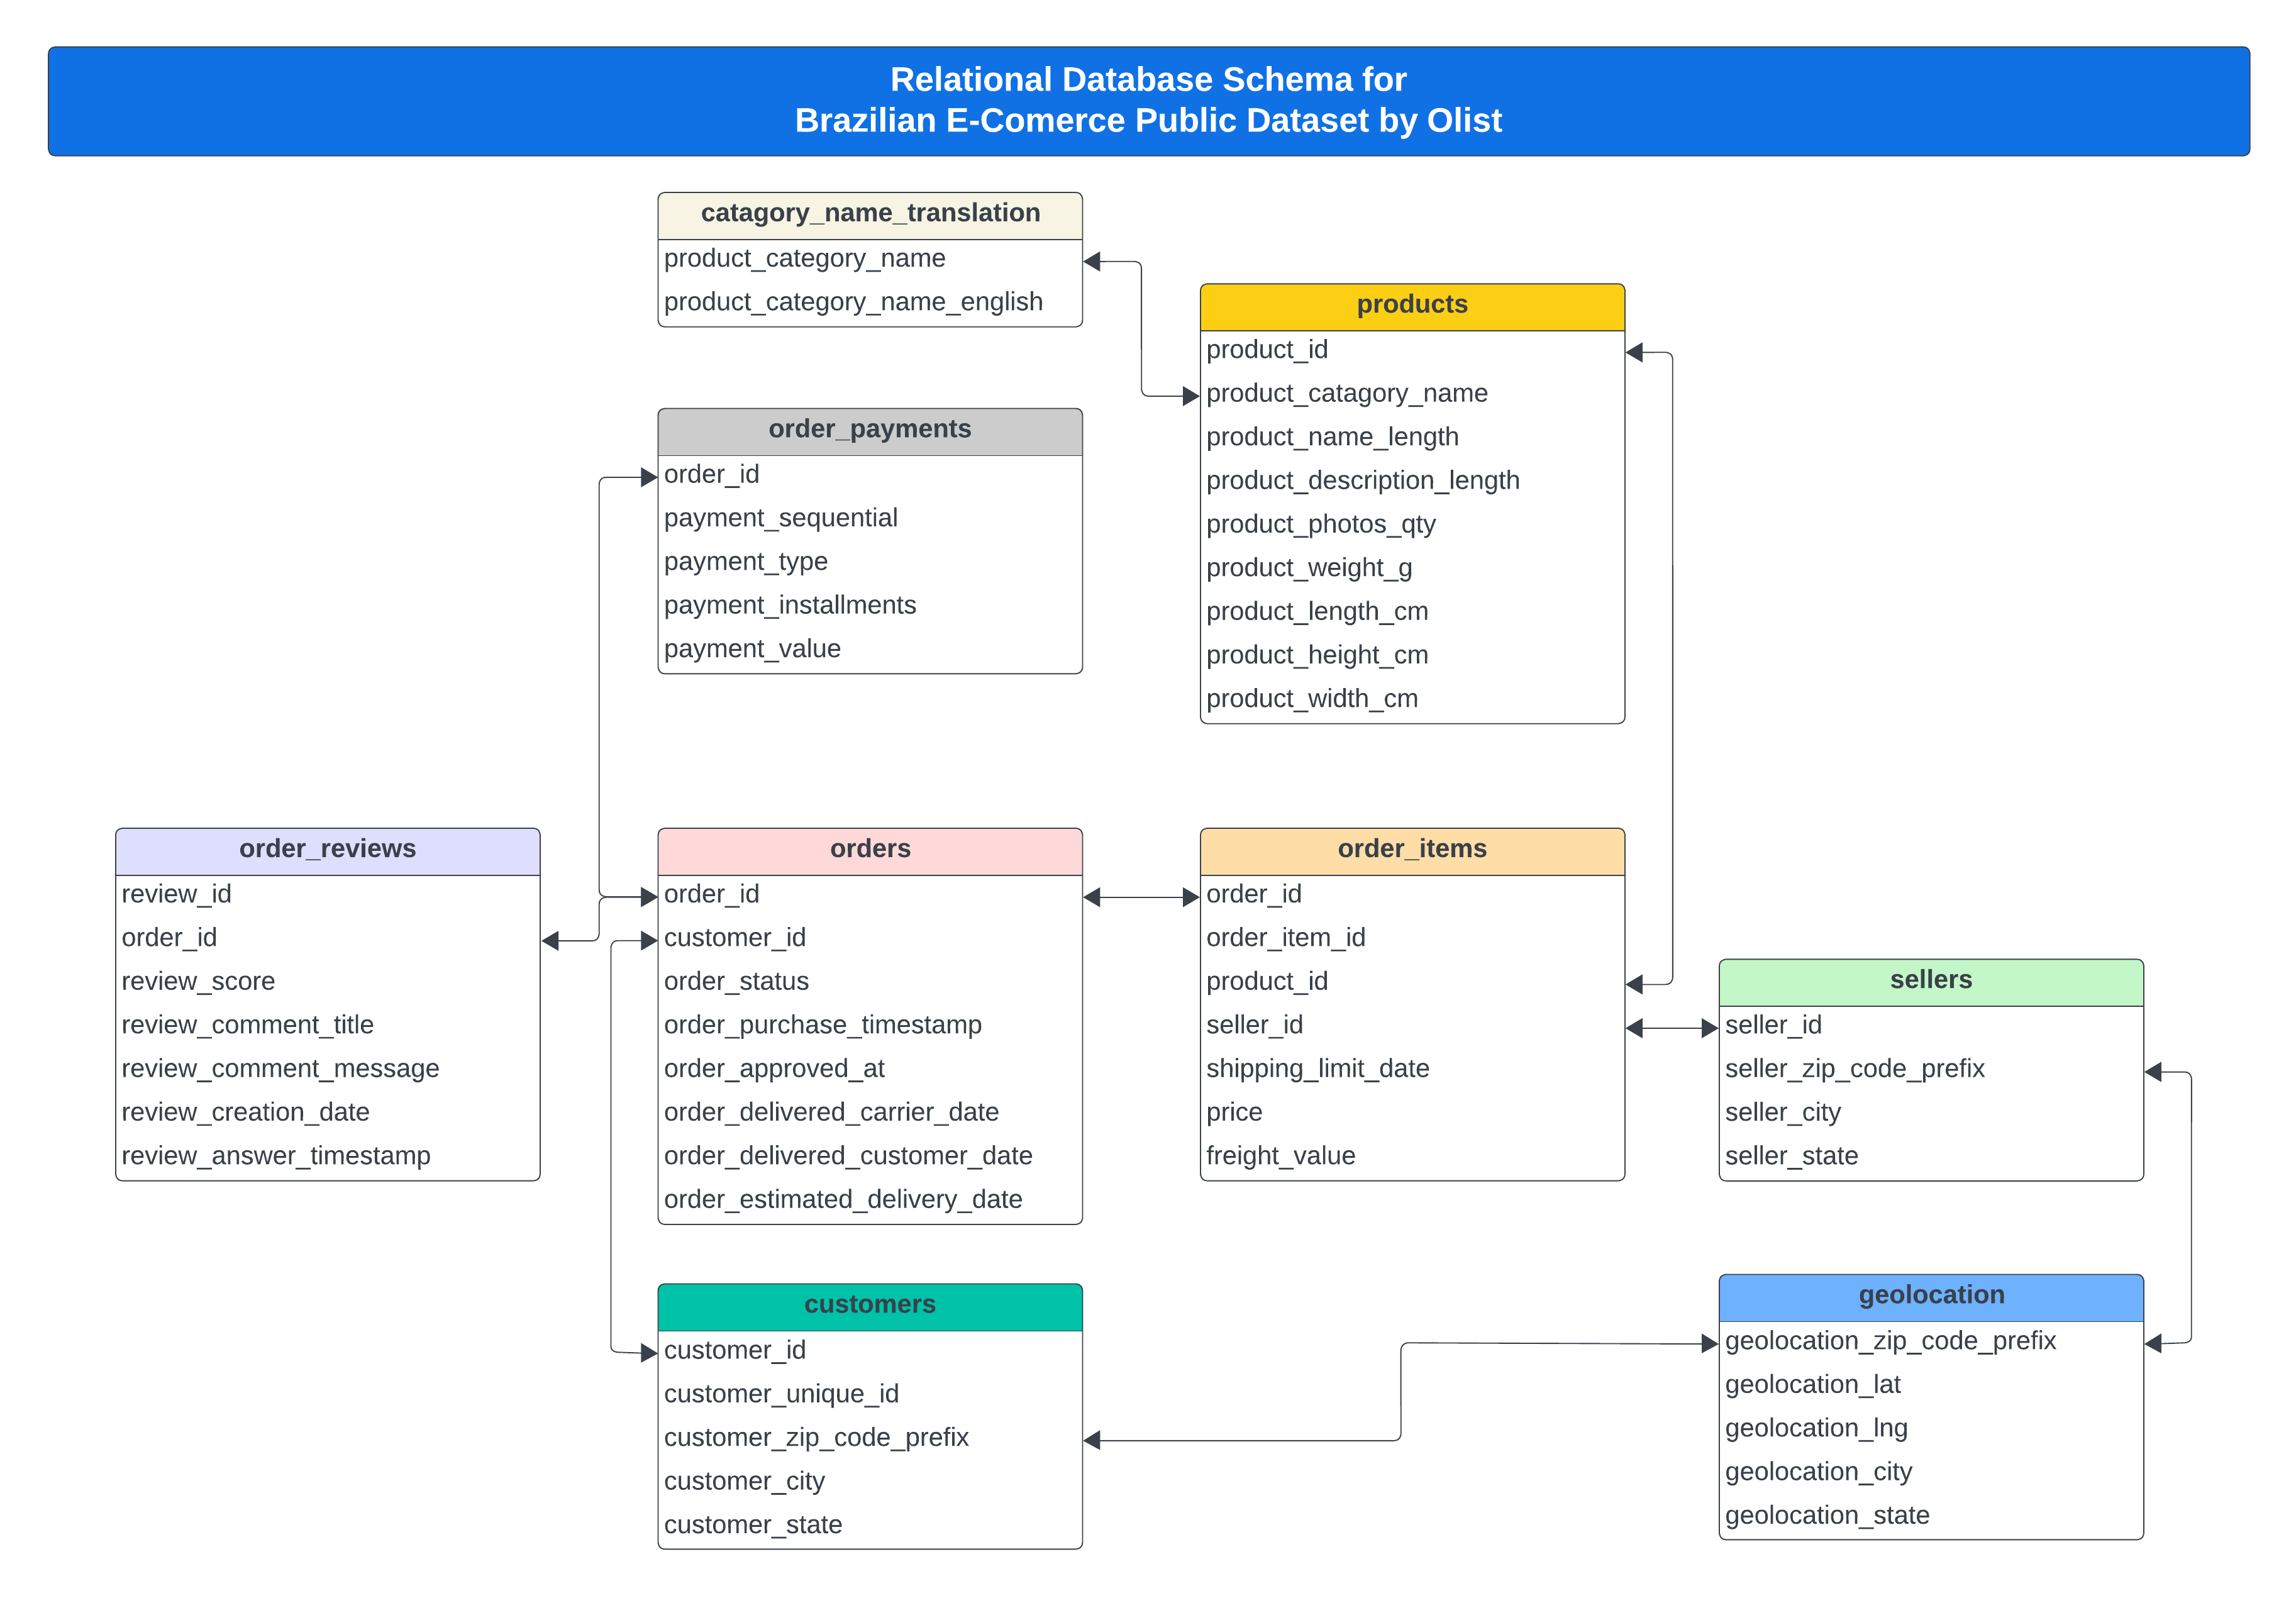

# Merging data


In [ ]:
df_olist = pd.merge(df_olist_orders, df_olist_order_items, on='order_id', how='left')
df_olist = pd.merge(df_olist, df_olist_products, on='product_id', how='inner')
df_olist = pd.merge(df_olist, df_olist_order_payments, on='order_id', how = 'left')
df_olist = pd.merge(df_olist, df_olist_order_reviews, on='order_id', how='left')
df_olist = pd.merge(df_olist, df_olist_customers, on='customer_id', how='right')
df_olist = pd.merge(df_olist, df_product_category_name_translation, on='product_category_name', how='inner')

df_olist.shape

(116576, 37)

In [ ]:
df_olist.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name_english
0,00e7ee1b050b8499577073aeb2a297a1,06b8999e2fba1a1fbc88172c00ba8bc7,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,1.0,credit_card,2.0,146.87,88b8b52d46df026a9d1ad2136a59b30b,4.0,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,office_furniture
1,b2059ed67ce144a36e2aa97d2c9e9ad2,4e7b3e00288586ebd08712fdd0374a03,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,1.0,credit_card,7.0,157.73,5ad6695d76ee186dc473c42706984d87,5.0,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,office_furniture
2,951670f92359f4fe4a63112aa7306eba,b2b6027bc5c5109e529d4dc6358b12c3,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,1.0,credit_card,1.0,173.30,059a801bb31f6aab2266e672cab87bc5,5.0,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,office_furniture
3,997fd4b37386d10b57d4ac8cdec011a6,4c06b42fbf7b97ab10779cda5549cd1c,delivered,2018-07-08 09:59:19,2018-07-08 10:30:15,2018-07-25 15:12:00,2018-08-08 19:42:53,2018-08-16 00:00:00,1.0,8ed094bfe076c568f6bb10feada3f75d,7c67e1448b00f6e969d365cea6b010ab,2018-07-26 10:30:15,199.98,115.77,moveis_escritorio,43.0,1128.0,1.0,16133.0,63.0,59.0,25.0,1.0,credit_card,6.0,315.75,2518803238cabbf63564593e4a8fc52d,1.0,Nada de produto,"Ainda não recebi o produto. Sendo assim, não p...",2018-08-09 00:00:00,2018-08-14 11:40:54,07d190f123147d9e89d4b922543d7948,65075,sao luis,MA,office_furniture
4,b63fff1ef8b6201df68bb611ee41129e,8276de07ef25225d412b8462d73f8664,delivered,2017-04-02 22:15:27,2017-04-04 05:55:19,2017-04-13 16:28:06,2017-05-02 13:53:25,2017-05-08 00:00:00,1.0,aba86c093ccdbac75b09111d57e50004,7c67e1448b00f6e969d365cea6b010ab,2017-04-17 05:55:19,129.60,16.61,moveis_escritorio,41.0,154.0,1.0,2600.0,40.0,45.0,39.0,1.0,boleto,1.0,146.21,84467f1766775ba4c14fc25b3ca67905,4.0,NaN,"A crítica é à entrega, pois por se tratar dos ...",2017-05-03 00:00:00,2017-05-03 21:06:33,332cf4e83e16004ba7dca932ce82475b,90010,porto alegre,RS,office_furniture


In [ ]:
def display_columns_info(df):
    columns_info = []
    for col in df.columns:
        null_count = df[col].isnull().sum()
        data_type = df[col].dtype
        rows_with_values = df[col].notnull().sum()
        columns_info.append([col, null_count, data_type, rows_with_values])

    columns_info_df = pd.DataFrame(columns_info, columns=['Column Name', 'Null Amount', 'Data Type', 'Number of Rows '])
    return columns_info_df

display_columns_info(df_olist)

,Column Name,Null Amount,Data Type,Number of Rows
0,order_id,0,object,116576
1,customer_id,0,object,116576
2,order_status,0,object,116576
3,order_purchase_timestamp,0,object,116576
4,order_approved_at,14,object,116562
5,order_delivered_carrier_date,1213,object,115363
6,order_delivered_customer_date,2515,object,114061
7,order_estimated_delivery_date,0,object,116576
8,order_item_id,0,float64,116576
9,product_id,0,object,116576


In [ ]:
quantity_of_orders = df_olist_orders['order_id'].nunique()
print(f'Zostało złożonych {quantity_of_orders} unikatowych zamówień')
df_olist.drop_duplicates(subset = 'order_id', inplace = True)
df_olist['order_id'].shape


Zostało złożonych 99441 unikatowych zamówień


(97256,)

# EDA


<ipython-input-13-a6615ba94b72>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




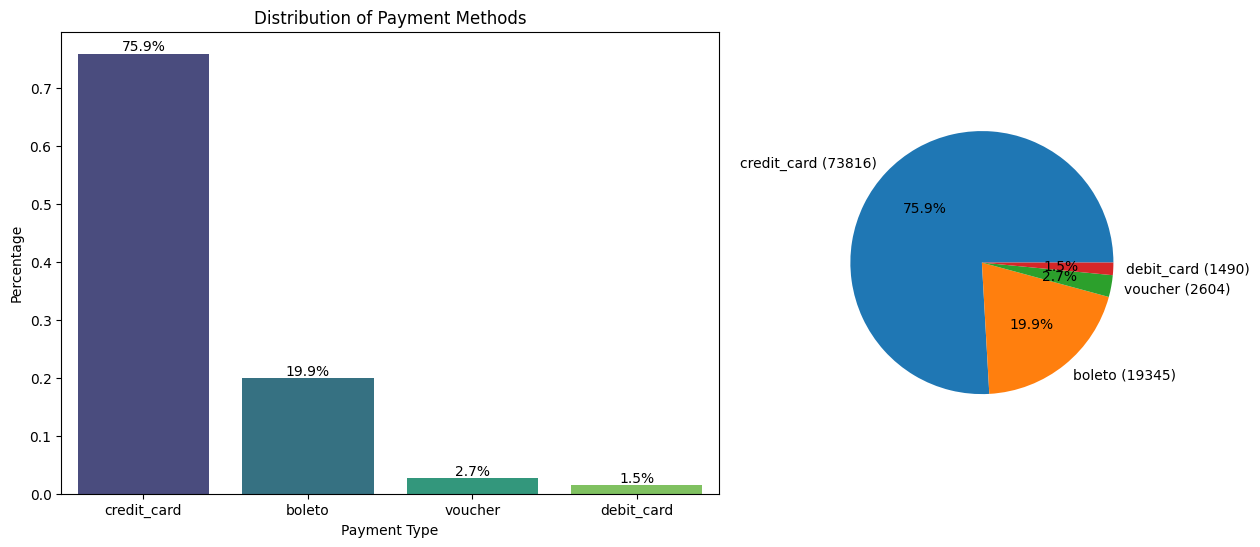

In [ ]:
payment_met_counts = df_olist['payment_type'].value_counts().to_dict()
payment_met_percentages = df_olist['payment_type'].value_counts(normalize=True).reset_index()
payment_met_percentages.columns = ['Payment Type', 'Percentage']

# Ustawienia wykresu słupkowego
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

# Wykres słupkowy
ax0 = plt.subplot(gs[0])
sns.barplot(x='Payment Type', y='Percentage', data=payment_met_percentages, palette='viridis', ax=ax0)

# Dodanie etykiet z procentami na słupkach
for p in ax0.patches:
    ax0.annotate(f"{p.get_height()*100:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

ax0.set_xlabel('Payment Type')
ax0.set_ylabel('Percentage')
ax0.set_title('Distribution of Payment Methods')

# Wykres kołowy
ax1 = plt.subplot(gs[1])
patches, texts, autotexts = ax1.pie(payment_met_counts.values(), labels=payment_met_counts.keys(), autopct='%1.1f%%', startangle=0)

# Dodanie liczby danych płatności obok etykiet
for text, autotext, count in zip(texts, autotexts, payment_met_counts.values()):
    text.set_text(f"{text.get_text()} ({count})")

ax1.set_title('')

# Pokazanie wykresu
plt.show()

<ipython-input-14-c6d8edc8c69b>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




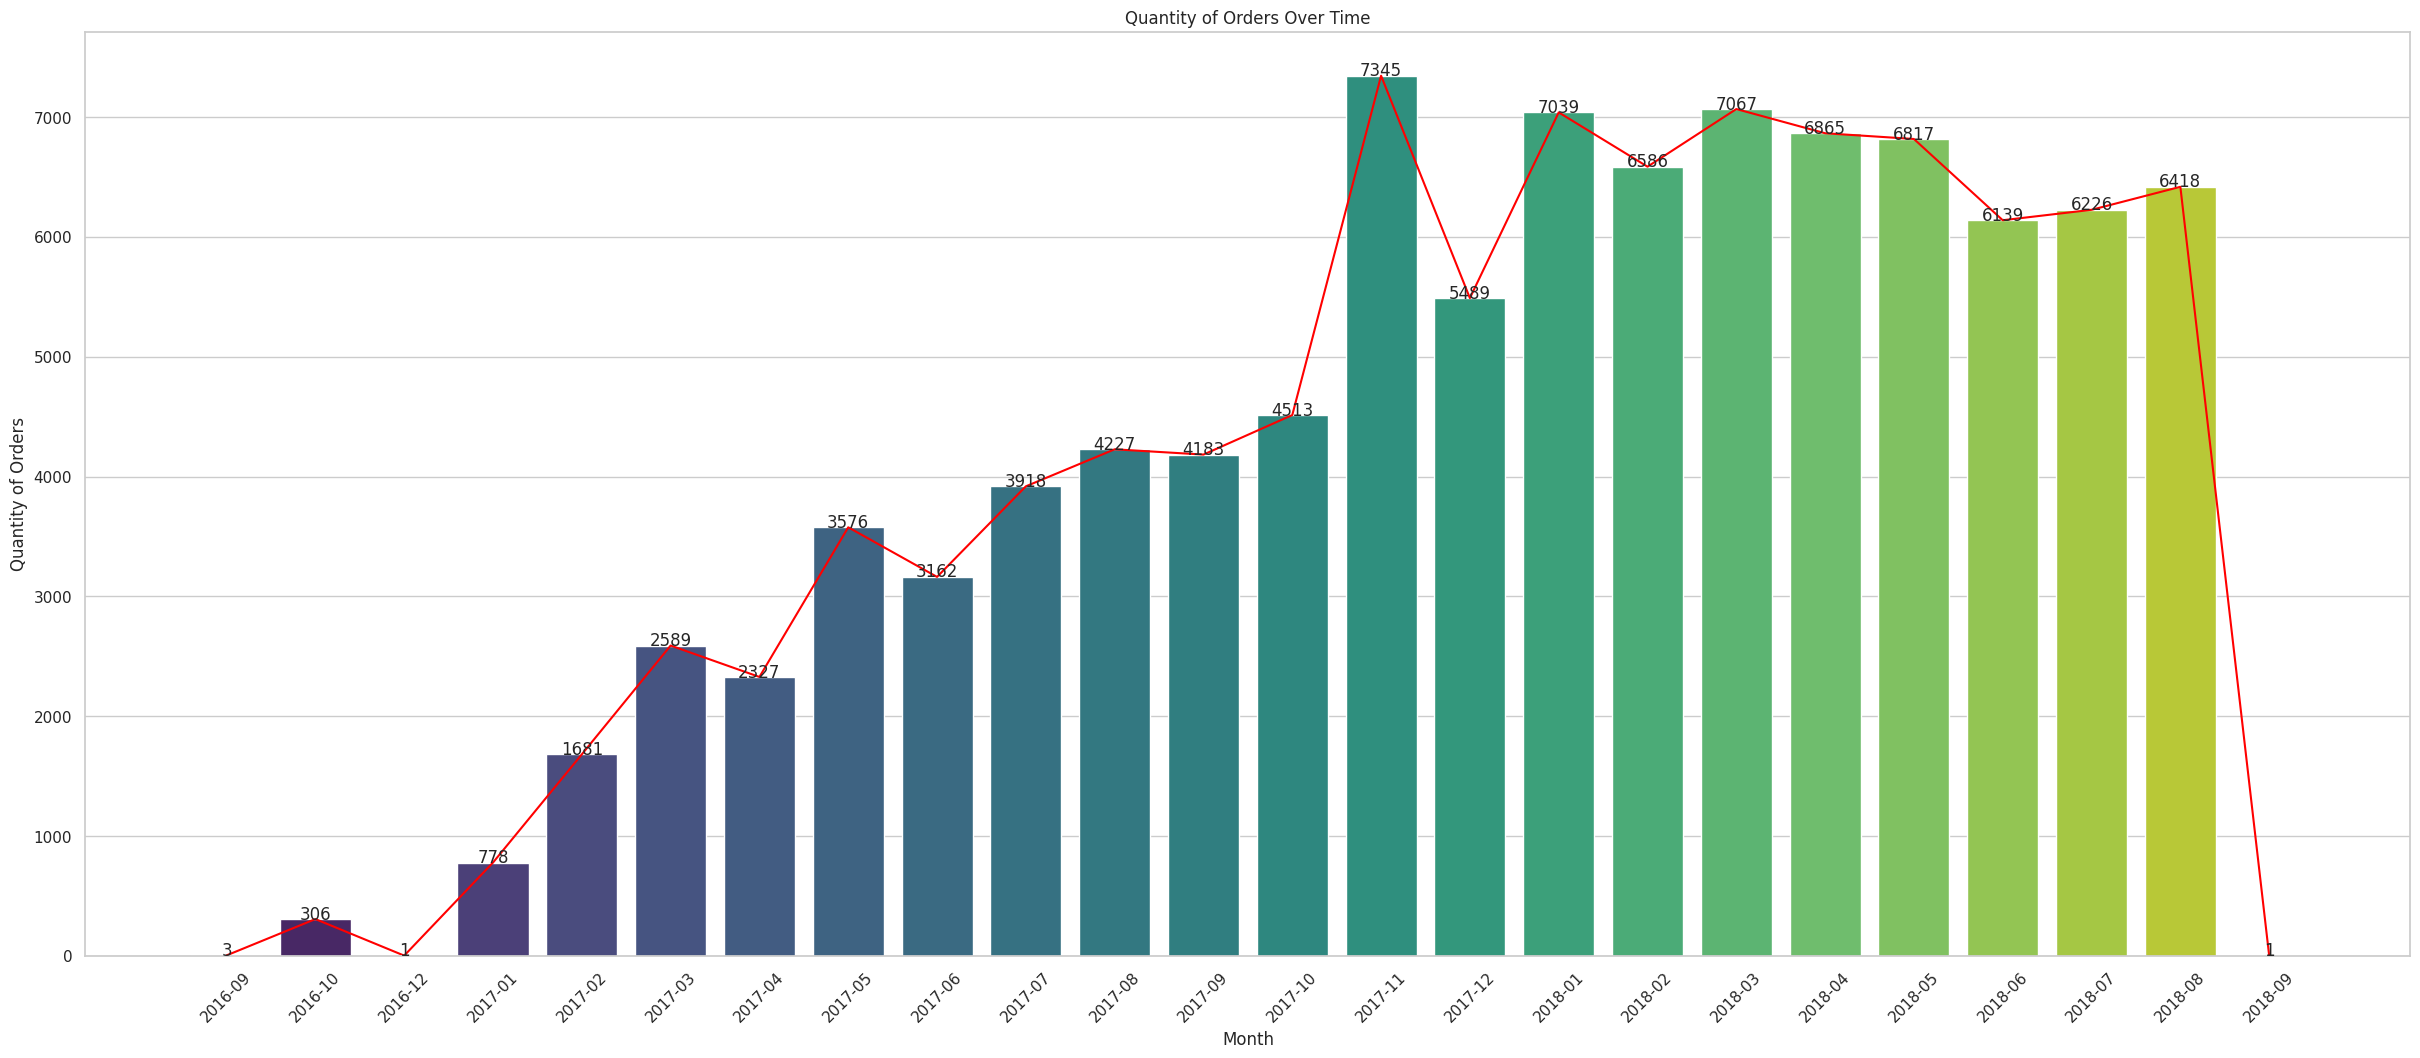

In [ ]:
df_orders_quantity = df_olist[['order_purchase_timestamp', 'price']].dropna()
df_orders_quantity['quantity_of_orders'] = 1
df_orders_quantity['order_purchase_timestamp'] = pd.to_datetime(df_orders_quantity['order_purchase_timestamp'])
#sortuje dane względem daty
df_orders_quantity = df_orders_quantity.sort_values(by='order_purchase_timestamp')

# Format 'YYYY-MM'
df_orders_quantity['order_purchase_timestamp'] = df_orders_quantity['order_purchase_timestamp'].dt.to_period("M")

# pogrupowane i zsumowane zamówienia dla każdego miesiąca
df_orders_quantity = df_orders_quantity.groupby('order_purchase_timestamp').agg({'quantity_of_orders': 'sum'}).reset_index()
df_orders_quantity.rename(columns={'order_purchase_timestamp': 'Month', 'quantity_of_orders': 'Quantity of orders'}, inplace=True)

# 'Month' na string
df_orders_quantity['Month'] = df_orders_quantity['Month'].astype(str)

#  'Quantity of orders' na liczby
df_orders_quantity['Quantity of orders'] = pd.to_numeric(df_orders_quantity['Quantity of orders'], errors='coerce')

# styl wykresu
sns.set(style="whitegrid")

# wykres
plt.figure(figsize=(30, 12))
barplot = sns.barplot(x='Month', y='Quantity of orders', data=df_orders_quantity, palette='viridis')

# Dodaj linię czerwoną
sns.lineplot(x='Month', y='Quantity of orders', data=df_orders_quantity, color='red', ax=barplot)

#oznaczenia nad słupkami
x = df_orders_quantity['Month']
y = df_orders_quantity['Quantity of orders']

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

# etykiety i tytuł
addlabels(x,y)
plt.xlabel('Month')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time')
plt.xticks(rotation=45)
plt.show()

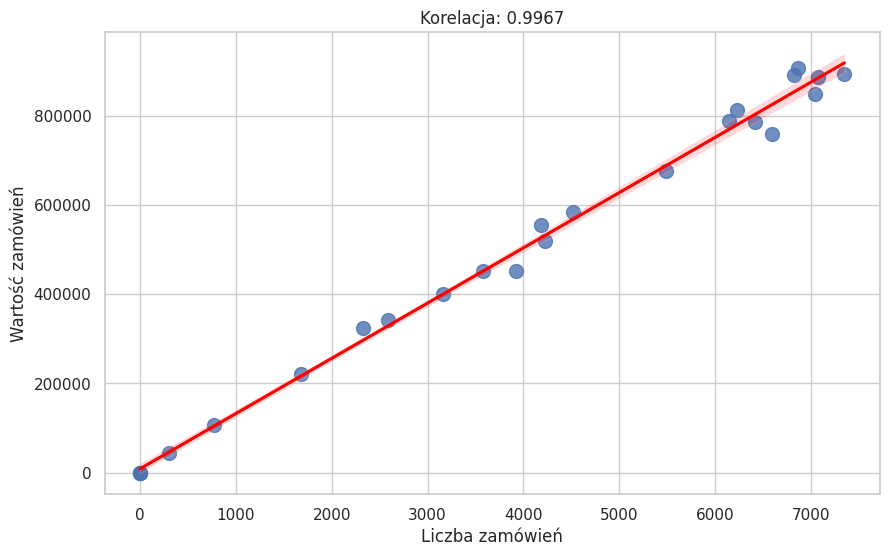

Średnia wartość koszyka zakupowego wynosi: 120.66


,Month,Quantity of orders,Revenue,Avredge shopping cart
0,2016-09,3,144.48,48.16
1,2016-10,306,45227.17,147.80
2,2016-12,1,10.90,10.90
3,2017-01,778,107026.87,137.57
4,2017-02,1681,220856.75,131.38
5,2017-03,2589,341282.14,131.82
6,2017-04,2327,323762.34,139.13
7,2017-05,3576,453128.64,126.71
8,2017-06,3162,400558.55,126.68
9,2017-07,3918,451241.51,115.17


In [ ]:
df_revenue = df_olist[['price', 'order_purchase_timestamp']]
df_revenue.rename(columns={'order_purchase_timestamp':'Month','quantity of orders	':'Quantity of orders	','price':'Revenue'}, inplace = True)

df_revenue['Month'] = df_revenue['Month'].str.slice(stop=7)
df_revenue['Quantity of orders'] = 1

df_revenue['Month'] = pd.to_datetime(df_revenue['Month'], format='%Y-%m')

# Grupuj według miesiąca i podlicz ilość zamówień i wartość zamówień
df_revenue = df_revenue.groupby(df_revenue['Month'].dt.to_period("M")).agg(
    {'Quantity of orders': 'sum', 'Revenue': 'sum'}).reset_index()

df_revenue.head(20)

correlation = df_revenue['Quantity of orders'].corr(df_revenue['Revenue'])
# Stwórz wykres punktowy z linią trendu
plt.figure(figsize=(10, 6))
sns.regplot(x='Quantity of orders', y='Revenue', data=df_revenue, scatter_kws={'s': 100}, line_kws={'color': 'red'})
#plt.scatter(df_revenue['Quantity of orders'], df_revenue['Revenue'])
plt.title(f'Korelacja: {correlation:.4f}')
plt.xlabel('Liczba zamówień')
plt.ylabel('Wartość zamówień')
plt.grid(True)
plt.show()


df_revenue['Avredge shopping cart'] = round( df_revenue['Revenue'] / df_revenue['Quantity of orders'] ,2)
avredge_value_of_shoppint_cart =round(df_revenue['Avredge shopping cart']. mean(), 2)
print(f'Średnia wartość koszyka zakupowego wynosi: {avredge_value_of_shoppint_cart}')
df_revenue.head(30)



<ipython-input-16-9392d6fd2600>:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




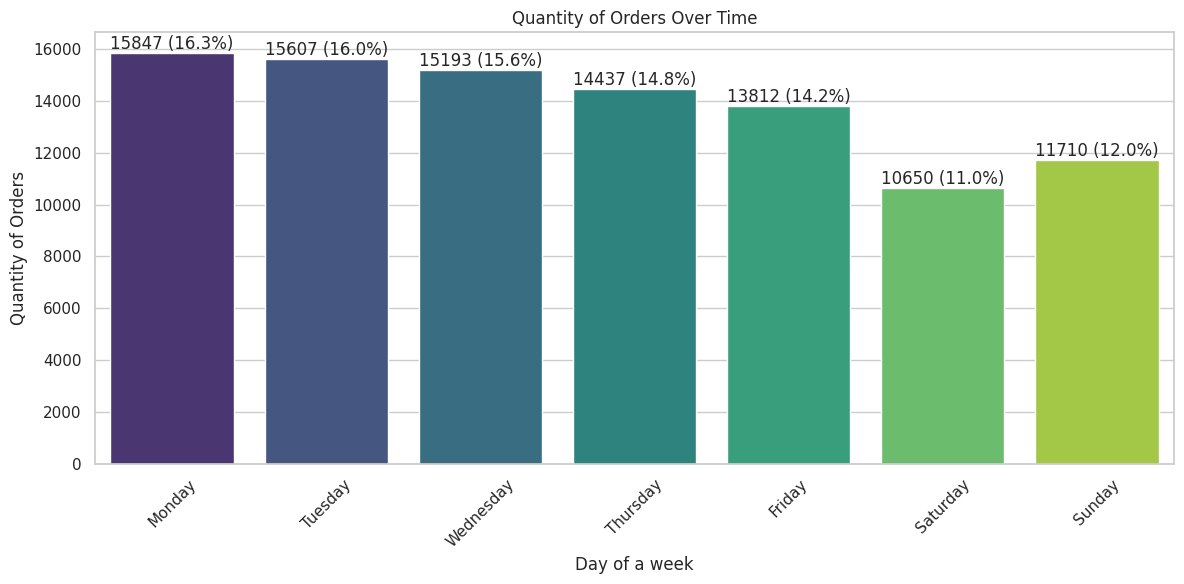

In [ ]:
#new dataframe
df_daytime = df_olist[['order_id', 'order_purchase_timestamp']]
df_daytime['order_purchase_timestamp'] = pd.to_datetime(df_daytime['order_purchase_timestamp'])
df_daytime['year'] = df_daytime['order_purchase_timestamp'].dt.year
df_daytime['month'] = df_daytime['order_purchase_timestamp'].dt.month
df_daytime['day'] = df_daytime['order_purchase_timestamp'].dt.day
df_daytime['month_name'] = df_daytime['order_purchase_timestamp'].dt.strftime('%B')
df_daytime['day_name'] = df_daytime['order_purchase_timestamp'].dt.strftime('%A')
df_daytime['day_of_week'] = (df_daytime['order_purchase_timestamp'].dt.dayofweek + 1)
df_daytime['hour'] = df_daytime['order_purchase_timestamp'].dt.hour
df_daytime['timeday'] = pd.cut(df_daytime['order_purchase_timestamp'].dt.hour, bins = [0,6,12,18,24], labels = ['Dawn', 'Morning' , 'Afternoon', 'Night'])
df_daytime.head(20)

#selected columns for bar plots
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week = df_daytime.groupby('day_name')['order_id'].nunique().sort_values(ascending=False).reindex(days_order)

#oznaczenia nad słupkami
x = day_of_week.index
y = day_of_week.values
#plot
sns.set(style="whitegrid")
sns.set_palette('viridis')
# wykres
plt.figure(figsize=(12,6))
dow_plot = sns.barplot(x=x, y=y, palette = 'viridis')



def addlabels(x,y):
    for i in range(len(x)):
         plt.text(i, y[i], f"{y[i]} ({y[i]/sum(y)*100:.1f}%)", ha='center', va='bottom')

# etykiety i tytuł
addlabels(x,y)
plt.xlabel('Day of a week')
plt.xlabel('Day of a week')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



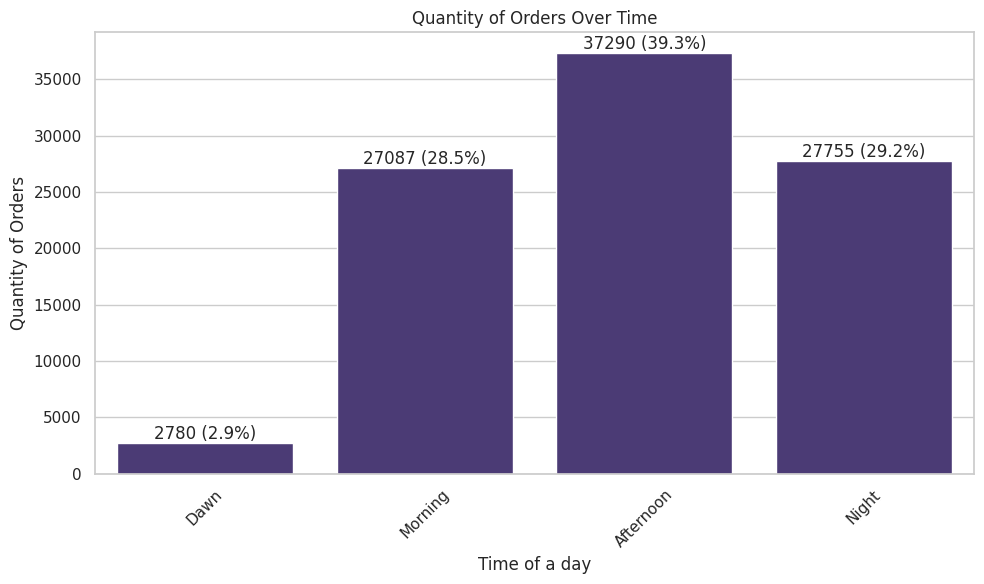

timeday
Dawn          2780
Morning      27087
Afternoon    37290
Night        27755
Name: order_id, dtype: int64


In [ ]:
time_of_day = df_daytime.groupby('timeday')['order_id'].nunique()

#plot
sns.set(style="whitegrid")
sns.set_palette('viridis')

#oznaczenia nad słupkami
x = time_of_day.index
y = time_of_day.values

# wykres
plt.figure(figsize=(10, 6))
tod_plot = sns.barplot(x=x, y=y)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], f"{y[i]} ({y[i]/sum(y)*100:.1f}%)", ha='center', va='bottom')

# etykiety i tytuł
addlabels(x,y)
plt.xlabel('Time of a day')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(time_of_day)

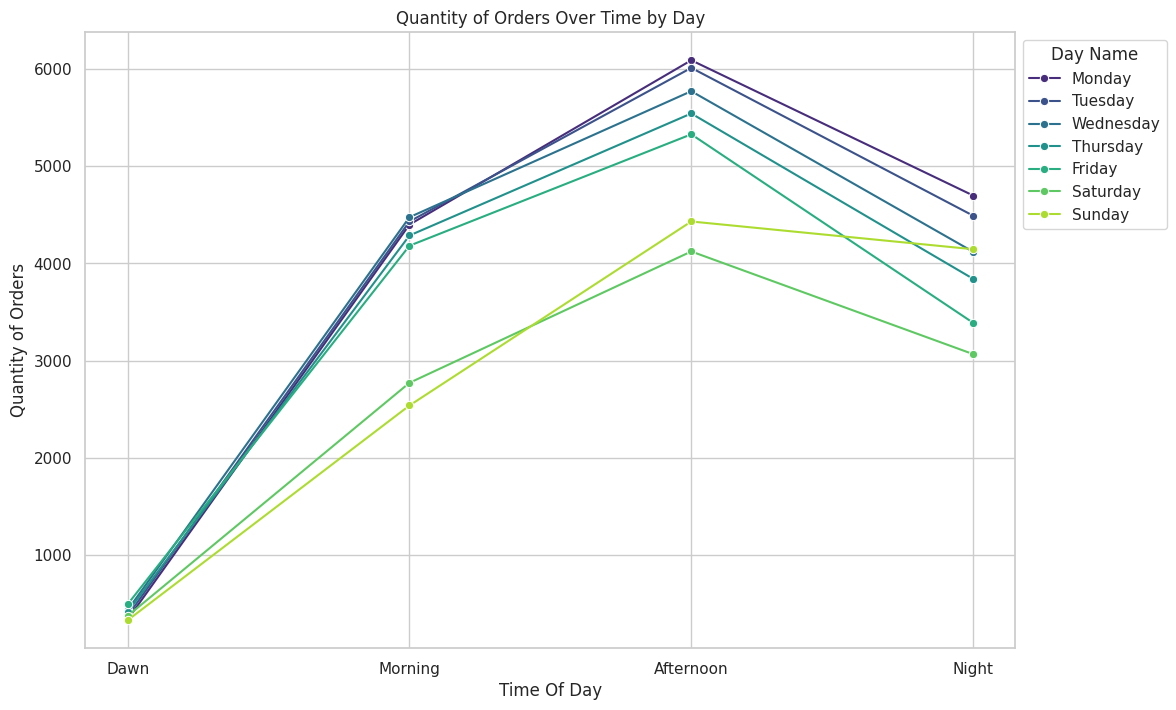

In [ ]:
df_weekly = df_daytime[['order_id','day_name','timeday','day', ]]
df_weekly['Combined'] = df_weekly['day_name'].str.cat(df_weekly['timeday'], sep=' ')
df_weekly_combined = df_weekly.groupby('Combined')[['order_id']].nunique().reset_index().rename(columns={'order_id':'Quantity of orders'})
df_weekly_combined[['Day Name', 'Time Of Day']] = df_weekly_combined['Combined'].str.split(expand = True, n=1)

sort_days = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}
sort_time = {'Dawn':1, 'Morning':2, 'Afternoon':3, 'Night':4}

df_weekly_combined['Sort by day'] = df_weekly_combined['Day Name'].map(sort_days)
df_weekly_combined['Sort by time'] = df_weekly_combined['Time Of Day'].map(sort_time)

df_weekly_combined.sort_values(by=["Sort by day", "Sort by time"],ascending=True, inplace = True)
df_weekly_combined.drop(columns=["Sort by day", "Sort by time"], inplace = True)

# Przygotowanie danych
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_order = ['Dawn', 'Morning', 'Afternoon', 'Night']

# Wybierz tylko odpowiednie dni i porę doby
df_plot = df_weekly_combined[df_weekly_combined['Day Name'].isin(days_order)]
df_plot = df_plot[df_plot['Time Of Day'].isin(time_order)]

# Ustawienie kolejności kategorii na osiach
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", n_colors=len(days_order))

# Tworzenie wykresu
plt.figure(figsize=(12, 8))
sns.lineplot(x='Time Of Day', y='Quantity of orders', hue='Day Name', data=df_plot, palette=palette, marker='o')

# Dostosowanie etykiet osi i tytułu
plt.xlabel('Time Of Day')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time by Day')

# Legenda
plt.legend(title='Day Name', bbox_to_anchor=(1, 1), loc='upper left')

# Pokazanie wykresu
plt.show()

<Figure size 1200x800 with 0 Axes>

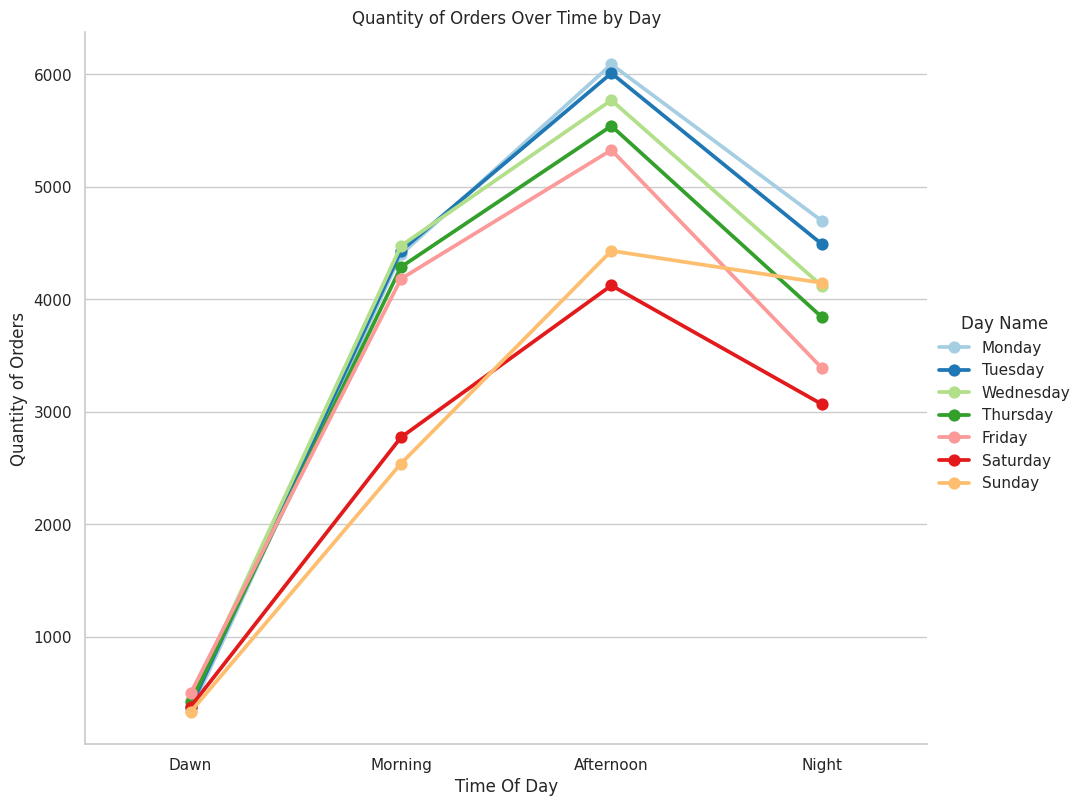

In [ ]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_order = ['Dawn', 'Morning', 'Afternoon', 'Night']

# Wybierz tylko odpowiednie dni i porę doby
df_plot = df_weekly_combined[df_weekly_combined['Day Name'].isin(days_order)]
df_plot = df_plot[df_plot['Time Of Day'].isin(time_order)]

# Ustawienie kolejności kategorii na osiach
sns.set(style="whitegrid")
palette = sns.color_palette("Paired", n_colors=len(days_order))

# Tworzenie wykresu
plt.figure(figsize=(12, 8))
sns.catplot(x='Time Of Day', y='Quantity of orders', hue='Day Name', data=df_plot, kind='point', palette=palette, height=8, aspect=1.2)

# Dostosowanie etykiet osi i tytułu
plt.xlabel('Time Of Day')
plt.ylabel('Quantity of Orders')
plt.title('Quantity of Orders Over Time by Day')

# Legenda
#plt.legend(title='Day Name', bbox_to_anchor=(1, 1), loc='upper left')

# Pokazanie wykresu
plt.show()


<ipython-input-20-2b1e2f354d96>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-20-2b1e2f354d96>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




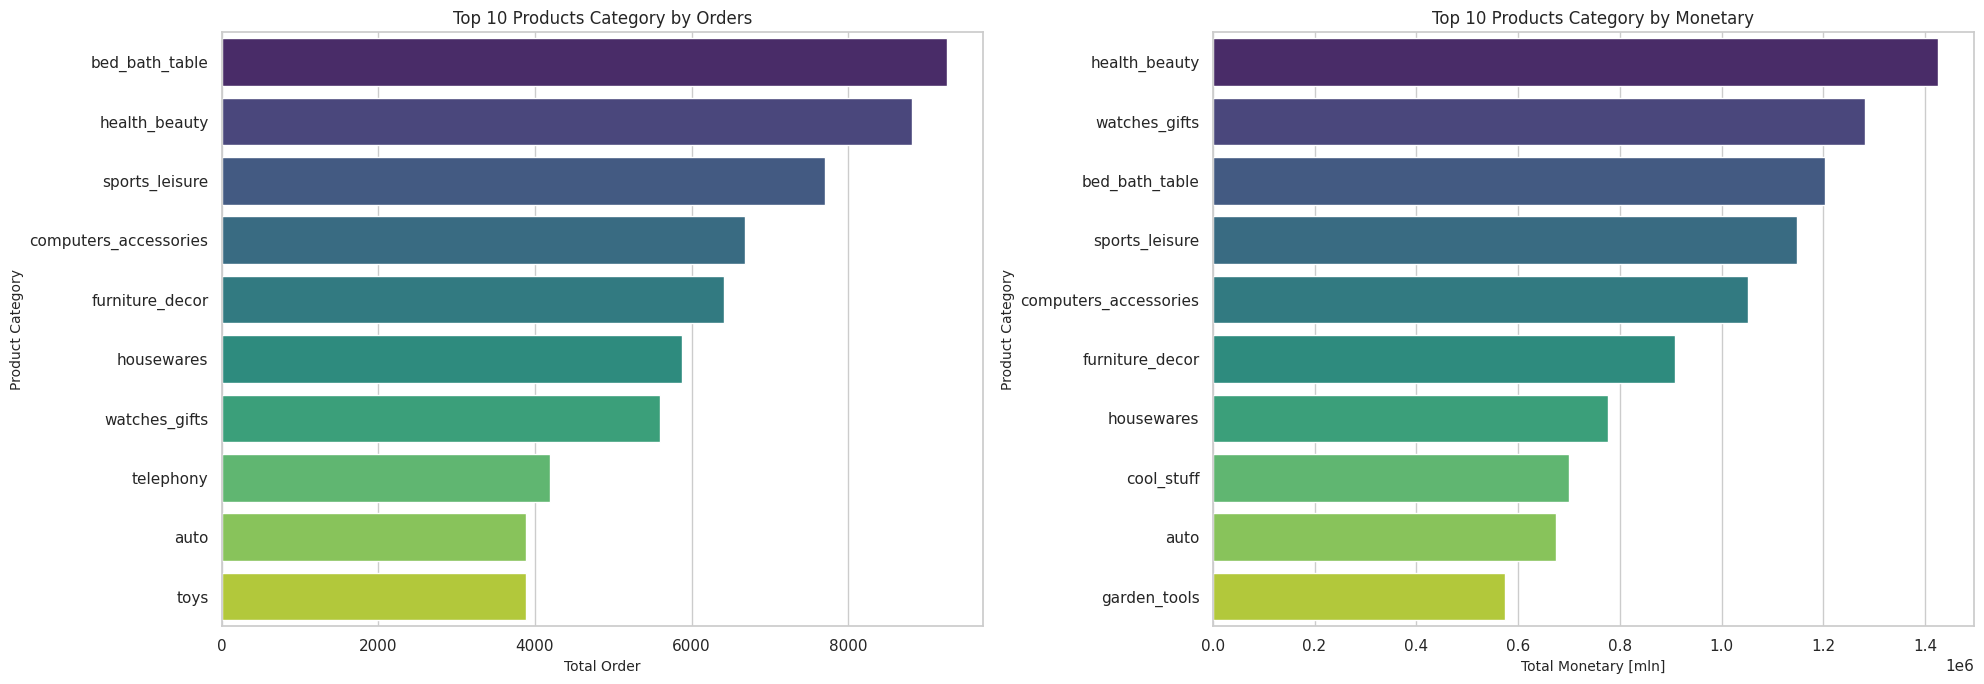

In [ ]:
# Group by top 10 products category by Total Order and Total Monetary
products_by_order = df_olist.groupby('product_category_name_english').count()[['order_id']].sort_values(by='order_id', ascending=False).reset_index()[:10]
product_by_payment_value = df_olist.groupby('product_category_name_english').sum()[['payment_value']].sort_values(by='payment_value', ascending=False).reset_index()[:10]

sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(20,7))

# Plot barplot [0]
sns.barplot(data=products_by_order, x='order_id', y='product_category_name_english', palette='viridis', ax=ax[0])
ax[0].set_title("Top 10 Products Category by Orders", fontdict={'fontsize':12})
ax[0].set_xlabel("Total Order", fontdict={'fontsize':10})
ax[0].set_ylabel("Product Category", fontdict={'fontsize':10})

# Plot barplot [1]
sns.barplot(data=product_by_payment_value, x='payment_value', y='product_category_name_english', palette="viridis", ax=ax[1])
ax[1].set_title("Top 10 Products Category by Monetary", fontdict={'fontsize':12})
ax[1].set_xlabel("Total Monetary [mln]", fontdict={'fontsize':10})
ax[1].set_ylabel("Product Category", fontdict={'fontsize':10})

# Make sure layout is not overlapping
fig.tight_layout()

# Show the graphs
fig.show()

<ipython-input-21-84540afeb9e7>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-21-84540afeb9e7>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




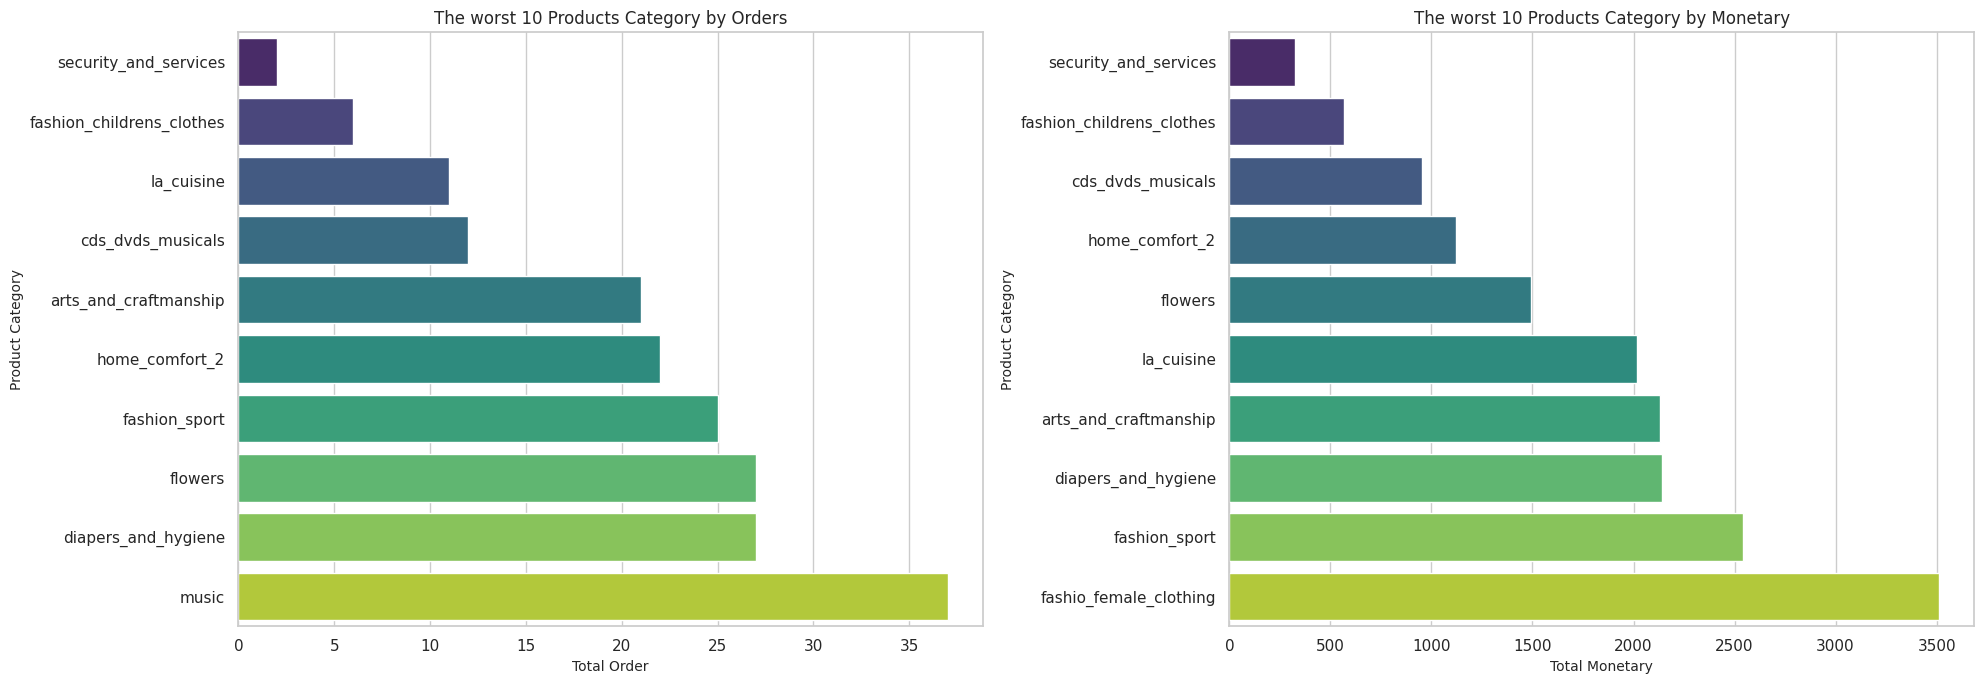

In [ ]:
# Group by the worst 10 products category by Total Order and Total Monetary
products_by_order = df_olist.groupby('product_category_name_english').count()[['order_id']].sort_values(by='order_id', ascending=True).reset_index()[:10]
product_by_payment_value = df_olist.groupby('product_category_name_english').sum()[['payment_value']].sort_values(by='payment_value', ascending=True).reset_index()[:10]

sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(20,7))

# Plot barplot [0]
sns.barplot(data=products_by_order, x='order_id', y='product_category_name_english', palette='viridis', ax=ax[0])
ax[0].set_title("The worst 10 Products Category by Orders", fontdict={'fontsize':12})
ax[0].set_xlabel("Total Order", fontdict={'fontsize':10})
ax[0].set_ylabel("Product Category", fontdict={'fontsize':10})

# Plot barplot [1]
sns.barplot(data=product_by_payment_value, x='payment_value', y='product_category_name_english', palette="viridis", ax=ax[1])
ax[1].set_title("The worst 10 Products Category by Monetary", fontdict={'fontsize':12})
ax[1].set_xlabel("Total Monetary", fontdict={'fontsize':10})
ax[1].set_ylabel("Product Category", fontdict={'fontsize':10})

# Make sure layout is not overlapping
fig.tight_layout()

# Show the graphs
fig.show()

<ipython-input-22-56a8b7d0fc61>:4: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



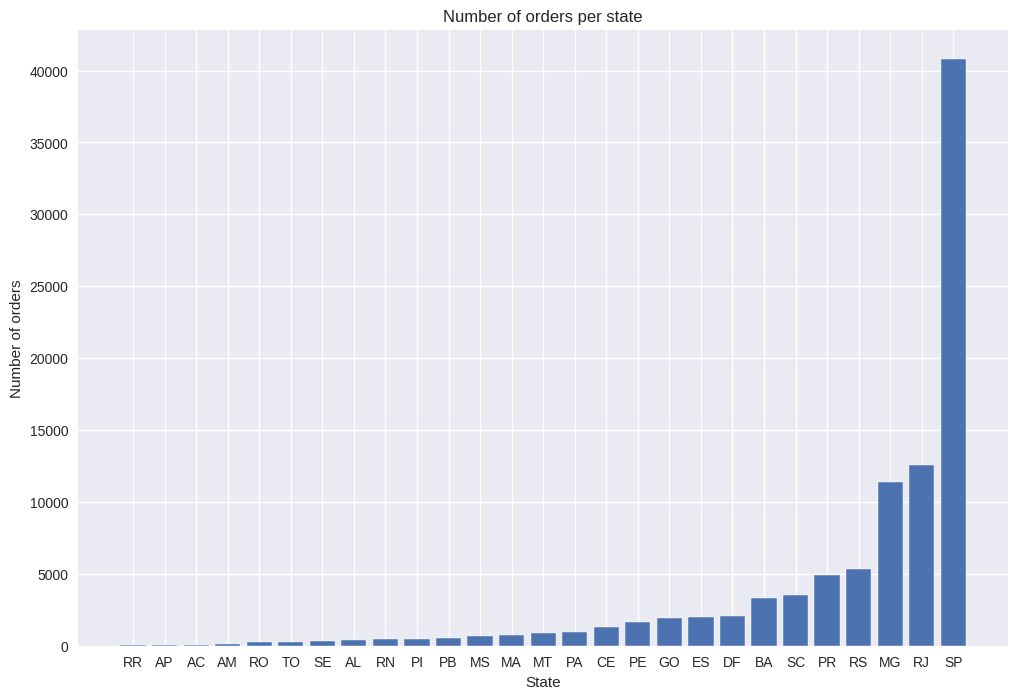

In [ ]:
customer_by_state = df_olist[['customer_unique_id', 'customer_state']].groupby('customer_state').count().reset_index()
customer_by_state = customer_by_state.sort_values(by=['customer_unique_id'])

plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.bar(customer_by_state['customer_state'], customer_by_state['customer_unique_id'])
plt.xlabel('State')
plt.ylabel('Number of orders')
plt.title('Number of orders per state')
plt.show()

In [ ]:
data = [go.Scattermapbox(
    lon = df_olist_geolocation['geolocation_lng'],
    lat = df_olist_geolocation['geolocation_lat'],
    text = df_olist_geolocation['geolocation_state'],
    marker = dict(
        size = 20,
        color = 'Tomato',
    ))]

layout = dict(
        title = 'Brazil State Recalculate Coordinate',
        mapbox = dict(
            accesstoken = 'pk.eyJ1IjoiZnJhYW5hcyIsImEiOiJjbHZlYWdhcTMwN2p2MmxsOTU4ZWQ2ZnplIn0.KpTd2M0AmkEtYD0Gka0wCQ',
            center= dict(lat=-22,lon=-43),
            bearing=10,
            pitch=0,
            zoom=2,
        )
    )
fig = dict( data=data, layout=layout )
iplot( fig, validate=False)

# Kohorts


In [ ]:
df_segmentation_time = df_olist[['order_purchase_timestamp', 'customer_unique_id', 'order_id', 'price']]
# Konwertuję kolumnę 'order_purchase_timestamp' na format daty, następnie filtruje, aby DF zawierał tylko dane z okresu 1.1.2017 - 31.8.2018
df_segmentation_time['order_purchase_timestamp'] = pd.to_datetime(df_segmentation_time['order_purchase_timestamp'])
df_segmentation_time = df_segmentation_time[(df_segmentation_time['order_purchase_timestamp'] >= '2017-01-01')
& (df_segmentation_time['order_purchase_timestamp'] <= '2018-08-31')]

min_date = df_segmentation_time['order_purchase_timestamp'].min()
max_date = df_segmentation_time['order_purchase_timestamp'].max()
print(f"Najwcześniejsza data: {min_date}, Najnowsza data: {max_date}")

def display_null_counts(df):
    for col in df.columns:
      null_count = df[col].isnull().sum()
      print(f'Kolumna {col} ma {null_count} watości null.')
    print(f'Kształt DataFrame: {df.shape}')

display_null_counts(df_segmentation_time)

In [ ]:
#Wybieram kolumne z unikalnym ID klienta aby sprawdzić ilu ich jest oraz obliczyć ile jest zamówień powracających.
unique_clientsID = df_segmentation_time['customer_unique_id'].nunique()
clientsID_in_DF = df_segmentation_time['customer_unique_id'].count()

multi_order_customers = df_segmentation_time['customer_unique_id'].duplicated(keep=False)
multi_order_orders = df_segmentation_time[multi_order_customers].shape[0]
percent = ((multi_order_orders / unique_clientsID)*100)
rounded = round(percent, 3)

print(f'Ogólna liczba ID klientów to : {clientsID_in_DF}.')
print(f'Liczba unikatowych ID to : {unique_clientsID}.')
print(f'Procent powracających klientów: {rounded} % ')
print(f'Liczba zamowien od klientów, którzy dokonali zamówienia ponad 1 raz: {multi_order_orders}')

In [ ]:
#Zostawiam tylko zduplikowane wiersze z 'customer_unique_id' ponieważ są to klienci, którzy zrobili zamówienie więcej niż 1 raz
multi_order_customers = df_segmentation_time['customer_unique_id'].value_counts() > 1
multi_order_customers = multi_order_customers[multi_order_customers].index
df_seg_time = df_segmentation_time[df_segmentation_time['customer_unique_id'].isin(multi_order_customers)]


def get_month(x) :
   return dt.datetime(x.year, x.month, 1)

# Tworzę nową kolumnę 'OrderMonth', która zawiera pierwszy dzień miesiąca z kolumny 'order_purchase_timestamp'
df_seg_time['OrderMonth'] = df_seg_time['order_purchase_timestamp'].apply(get_month)
# Grupuję dane według 'customer_unique_id' i wybieram najwcześniejszy 'OrderMonth' dla każdego klienta
grouping = df_seg_time.groupby('customer_unique_id')['OrderMonth']
df_seg_time['AcquisitionMonth'] = grouping.transform('min')

df_seg_time.shape

In [ ]:
def get_date_int (df, column):
  year = df[column].dt.year
  month = df[column].dt.month
  day = df[column].dt.day
  return year, month, day

order_year, order_month, _ = get_date_int(df_seg_time, 'OrderMonth')
acqusiition_year, acqusiition_month, _ = get_date_int(df_seg_time, 'AcquisitionMonth')
# Obliczam różnice w latach i miesiącach między 'OrderMonth' i 'AcquisitionMonth'
years_diff = order_year - acqusiition_year
months_diff = order_month - acqusiition_month
# Obliczam indeks kohorty, przekształcając różnice w latach i miesiącach na liczbę miesięcy i dodając 1, aby uzyskać indeks kohorty
df_seg_time['CohortIndex'] = years_diff * 12 + months_diff + 1

grouping = df_seg_time.groupby(['AcquisitionMonth', 'CohortIndex'])
# Tworzę DataFrame `cohort_counts`, w którym wartości z kolumny 'customer_unique_id' są przekształcane  w liczbę klientów w kohorcie. Wiersze reprezentują kolejne miesiące pozyskania klientów,
# a kolumny reprezentują kolejne miesiące od pozyskania.
cohort_data = grouping['customer_unique_id'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index= 'AcquisitionMonth',
                                  columns = 'CohortIndex',
                                  values = 'customer_unique_id')
cohort_counts


In [ ]:
# Obliczam rozmiar kohorty jako liczby klientów w pierwszym miesiącu, następnie dziele każdy następny okres przed liczbę z pierwszego okresu
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis = 0)
retention.loc['2017-01-01'] = retention.loc['2017-01-01'].fillna(0)
retention.round(2)*100

In [ ]:
# Obliczam średnią wartość ceny dla każdej kohorty
grouping = df_seg_time.groupby(['AcquisitionMonth', 'CohortIndex' ])
cohort_data = grouping['price'].mean()
cohort_data = cohort_data.reset_index()
avrege_quantity = cohort_data.pivot(index = 'AcquisitionMonth',
                                    columns = 'CohortIndex',
                                    values = 'price')
avrege_quantity.round(1)


In [ ]:
plt.figure(figsize = (12,9))
plt.title('Customer retention rate')
sns.heatmap(data=retention,
            annot = True,
            fmt = '.0%',
            vmin = 0,
            vmax = 0.10,
            cmap = 'BuGn')
plt.show()

#RFM


In [ ]:
# Dodaje do ostatniej daty zamówienia jeden dzień
last_day = max(df_segmentation_time.order_purchase_timestamp) + dt.timedelta(days = 1 )
# Agreguje dane
datamart = df_segmentation_time.groupby(['customer_unique_id']).agg({
    'order_purchase_timestamp':lambda x: (last_day - x.max()).days,     # Obliczam dni od ostatniego zamówienia do daty zakończenia analizy (Recency)
    'order_id' : 'count',
    'price' : 'sum'
})
datamart.rename(columns = {
                           'order_purchase_timestamp': 'Recency',
                           'order_id': 'Frequency',
                           'price':'MonetaryValue'}, inplace = True)
datamart = datamart.rename_axis('CustomerID')
datamart.head(10)

In [ ]:
datamart['Frequency'].value_counts()

In [ ]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1); sns.distplot(datamart['Recency']),
plt.axvline(datamart['Recency'].mean(), c = 'red')
plt.axvline(datamart['Recency'].median(), c = 'black')
plt.xlim(0, 800)

plt.subplot(3, 1, 2); sns.distplot(datamart['Frequency'])
plt.axvline(datamart['Frequency'].mean(), c = 'red')
plt.axvline(datamart['Frequency'].median(), c = 'black')
plt.xlim(0, 8)

plt.subplot(3, 1, 3); sns.distplot(datamart['MonetaryValue'])
plt.axvline(datamart['MonetaryValue'].mean(), c = 'red')
plt.axvline(datamart['MonetaryValue'].median(), c = 'black')
plt.xlim(0, 1500)

plt.show()

In [ ]:
rfm_datamart = datamart.copy()

r_labels = range(4, 0, -1)
m_labels = range(1,5)

r_quartiles = pd.qcut(rfm_datamart['Recency'], q=4, labels = r_labels)
def adjust_frequency(row):
    if row['Frequency'] == 1:
        return 1
    elif row['Frequency'] == 2:
        return 2
    elif row['Frequency'] == 3:
        return 3
    else:
        return 4
m_quartiles = pd.qcut(rfm_datamart['MonetaryValue'], q=4, labels = m_labels)

rfm_datamart = rfm_datamart.assign(R = r_quartiles.values)
rfm_datamart = rfm_datamart.assign(F = rfm_datamart.apply(adjust_frequency, axis=1))
rfm_datamart = rfm_datamart.assign(M = m_quartiles.values)

rfm_datamart = rfm_datamart[['Recency', 'Frequency', 'MonetaryValue', 'R', 'F', 'M']]

def join_rfm(x):
    return ''.join(map(str, [int(x['R']), int(x['F']), int(x['M'])]))

rfm_datamart['RFM_segment'] = rfm_datamart.apply(join_rfm, axis = 1)
rfm_datamart['RFM_score'] = rfm_datamart[['R', 'F', 'M']].sum(axis = 1)


rfm_datamart.head()

In [ ]:
rfm_datamart.groupby('RFM_segment').size().sort_values(ascending = False)[:20]

In [ ]:
rfm_datamart.groupby('RFM_score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'MonetaryValue' : ['mean', 'count']}).round(1)


In [ ]:
datamart['Frequency'].value_counts()

In [ ]:
def segment_client(df):
    if df['RFM_score'] >= 9:
        return 'High segment'
    elif  (6 <= df['RFM_score'] < 9):
        return 'Medium segment'
    else:
        return 'Low segment'

rfm_datamart['General_segment'] = rfm_datamart.apply(segment_client, axis=1)
custom_order = ['High segment', 'Medium segment', 'Low segment']
rfm_datamart['General_segment'] = pd.Categorical(rfm_datamart['General_segment'], categories=custom_order, ordered=True)

result = rfm_datamart.groupby('General_segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

result = result.loc[custom_order]
result

# Data preprocessing to alghoritm Kmeans


In [ ]:
datamart.describe().round(2)

In [ ]:
scaler = StandardScaler()
scaler.fit(datamart)
datamart_normalized = scaler.transform(datamart)
columns_name = ['Recency', 'Frequency', 'MonetaryValue']
df_normalized = pd.DataFrame(datamart_normalized, columns = columns_name)
df_normalized.describe().round(2)

# Kmeans


In [ ]:
start_time = time.time()
end_time = time.time()
def calculate_loading_time(start_time, end_time):
    duration = end_time - start_time
    if duration < 60:
        # Czas ładowania jest mniejszy niż 60 sekund
        loading_time = f"{duration:.3f} sekundy"
    else:
        # Czas ładowania jest większy niż 60 sekund, konwertuj na minuty i sekundy
        minutes = int(duration // 60)
        seconds = duration % 60
        loading_time = f"{minutes} minut {seconds:.3f} sekundy"

    return loading_time



In [ ]:
start_time
# Inicjalizacja pustego słownika dla sumy kwadratów błędów (SSE)
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)  # Inicjalizacja KMeans dla aktualnego k
    kmeans.fit(datamart)  # Dopasowanie KMeans do znormalizowanych danych
    sse[k] = kmeans.inertia_  # Przypisanie SSE dla aktualnego k
end_time
loading_time = (end_time - start_time)

# Pobram etykiety klastrów z ostatniej iteracji KMeans
cluster_labels = kmeans.labels_
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()
print(f"Czas ładowania algorytmu: {loading_time}")

In [ ]:
n_clusters = [ 3, 4, 5, 6, 7, 8, 9 , 10]
silhouette_scores = []
start_time = time.time()
for K in n_clusters:
    initialized_clusters = KMeans(n_clusters = K, random_state = 10)
    data_fitted_clusters = initialized_clusters.fit_predict(datamart)

    silhouette_avg = silhouette_score(datamart, data_fitted_clusters)
    print(
        "For n_clusters =",
        K,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    sample_silhouette_values = silhouette_samples(datamart, data_fitted_clusters)

    #silhoette_score = silhouette_score(datamart, data_fitted_clusters, random_state = 42)
    #silhouette_scores.append(silhoette_score)

#plt.plot(n_clusters, silhouette_scores, color = 'b', marker = '*')
#plt.title('Cluster Scores', fontsize = 15)
#plt.xlabel('Number of Clusters', fontsize = 12)
#plt.ylabel('Silhouette Score', fontsize = 12)
#plt.show()

In [ ]:
y_lower = 10
for i in range(K):
    ith_cluster_silhouette_values = sample_silhouette_values[data_fitted_clusters == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper +


ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")



In [ ]:
start_time
sse = {}
for k in range(1,11):
  kmeans = KMeans(n_clusters=k, random_state = 10)
  kmeans.fit(datamart)
  sse[k] = kmeans.inertia_
  plt.title('The Elbow Method')
end_time
loading_time = (end_time - start_time)

plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()
print(f"Czas ładowania algorytmu: {loading_time} sekundy")

# Cluster analysis


In [ ]:
datamart_k2 = datamart.assign(Cluster = cluster_labels)
datamart_k2.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

In [ ]:
silhouette_score(datamart, cluster_labels).round(3)

In [ ]:
datamart.head()

In [ ]:
kmeans = KMeans(n_clusters=4, init = 'k-means++', random_state = 1)
kmeans.fit(datamart)
df_segm4_Kmeans = datamart.copy()
df_segm4_Kmeans['segment'] = kmeans.labels_
df_segm4_Kmeans.head()
df_segment4_grouped = df_segm4_Kmeans.groupby(['segment']).agg({
      'Recency': 'mean',
      'Frequency': 'mean',
      'MonetaryValue': ['mean', 'count']
}).round(1)

df_segment4_grouped

In [ ]:
kmeans = KMeans(n_clusters=5, init = 'k-means++', random_state = 1)
kmeans.fit(datamart)
df_segm5_Kmeans = datamart.copy()
df_segm5_Kmeans['segment'] = kmeans.labels_
df_segm5_Kmeans.head()
df_segment5_grouped = df_segm5_Kmeans.groupby(['segment']).agg({
      'Recency': 'mean',
      'Frequency': 'mean',
      'MonetaryValue': ['mean', 'count']
}).round(1)

df_segment5_grouped

In [ ]:
df_segm4_Kmeans['segment'].value_counts()

In [ ]:
df_segm4_Kmeans[df_segm4_Kmeans['segment'] == 1 ].head()

In [ ]:
df_analysis = df_segm4_Kmeans.groupby('segment').mean().round(2)

df_analysis['#observations'] = df_segm4_Kmeans[['segment','Frequency']].groupby(['segment']).count()
df_analysis['Percentage'] = df_analysis['#observations'] / df_analysis['#observations'].sum()
df_analysis['Percentage'].round(3)
df_analysis.round(3)

In [ ]:
x_axis = df_segm5_Kmeans['MonetaryValue']
y_axis = df_segm5_Kmeans['Recency']
plt.figure(figsize = (10,6))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm5_Kmeans['segment'],
                palette = 'Set2', legend = 'full')
plt.show()

In [ ]:
y_axis = df_segm5_Kmeans['Frequency']
x_axis = df_segm5_Kmeans['Recency']
plt.figure(figsize = (10,6))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm5_Kmeans['segment'],
                palette = 'Set2', legend = 'full')
plt.show()

In [ ]:
x_axis = df_segm5_Kmeans['MonetaryValue']
y_axis = df_segm5_Kmeans['Frequency']
plt.figure(figsize = (10,6))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm5_Kmeans['segment'],
                palette = 'Set2', legend = 'full')
plt.show()

In [ ]:
# Inicjalizacja figury i osi 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for segment in range(5):  # 5 klastrów
    segment_data = df_segm5_Kmeans[df_segm5_Kmeans['segment'] == segment]
    ax.scatter(segment_data['Recency'], segment_data['Frequency'], segment_data['MonetaryValue'], label=f'Segment {segment}')

# Ustawienie tytułów dla osi
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')

# Dodanie legendy
ax.legend()

# Wyświetlenie wykresu
plt.title('Wykres 3D dla segmentów KMeans')
plt.show()

In [ ]:
pca = PCA(n_components = 3)

pca.fit(datamart_normalized)

PC1_label = "PC1 {}%".format(round((100*pca.explained_variance_ratio[0]),2))
PC2_label = "PC2 {}%".format(round((100*pca.explained_variance_ratio[1]),2))
PC3_label = "PC3 {}%".format(round((100*pca.explained_variance_ratio[2]),2))

In [ ]:
figPCA = px.scatter_3d(segment_data, x = df_segm5_Kmeans['Recency'], y =  df_segm5_Kmeans['Frequency'], z = df_segm5_Kmeans['MonetaryValue'],
                       title = "Wykres 3D dla segmentów KMeans",
                       template = 'plotly_white', height = 800, width = 800)

figPCA.show()

In [ ]:
segment_data[segment_data['segment'] != 4].head()
df_segm5_Kmeans.head()

# More data to alghoritm



In [ ]:
df_olist.head(10)

In [ ]:
df = df_olist[['order_id', 'customer_id','customer_unique_id', 'order_purchase_timestamp', 'product_category_name', 'product_category_name_english', 'payment_installments', 'payment_type','price', 'review_score', 'review_comment_message', 'review_comment_title', 'customer_zip_code_prefix', 'customer_city', 'customer_state' ]]
df.head()

In [ ]:
df.isnull().sum()

Usuwam wartosci: payment_installments, payment_type ,review_score.

Wartości: review_comment_message, review_comment_title zamienam na układ binarny gdzie 1-zostawil wiadomosc/tytul, 0-nie zostawil


In [ ]:
df = df.dropna(subset = ['payment_installments', 'payment_type','review_score'])
df.isnull().sum()

In [ ]:
def text_handler(value):
  if pd.isnull(value):
    return 0
  else:
    return 1

df['review_comment_message'] = df['review_comment_message'].apply(lambda x: text_handler(x))
df['review_comment_title'] = df['review_comment_title'].apply(lambda x: text_handler(x))

df.isnull().sum()

In [ ]:
df['product_category_name_english'].value_counts()[:10]

In [ ]:
df.head()

In [ ]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df = df[(df['order_purchase_timestamp'] >= '2017-01-01') & (df['order_purchase_timestamp'] <= '2018-08-31')]

In [ ]:
last_date = max(df.order_purchase_timestamp) + dt.timedelta(days = 1 )
first_date = min(df.order_purchase_timestamp)
print(f'First date: {first_date} AND last date: {last_date}')

In [ ]:
df_extended = df.groupby(['customer_unique_id']).agg({
    'order_purchase_timestamp':lambda x: (last_date - x.max()).days,
    'order_id' : 'count',
    'price' : 'sum'})

df_extended.rename(columns = {
                           'order_purchase_timestamp': 'Recency',
                           'order_id': 'Frequency',
                           'price':'MonetaryValue'},
                            inplace = True)
df_extended.reset_index(inplace=True)

additional_columns = df[['customer_unique_id', 'product_category_name_english', 'payment_installments', 'payment_type', 'review_score', 'review_comment_message', 'review_comment_title', 'customer_zip_code_prefix', 'customer_city', 'customer_state']]
df_extended = df_extended.merge(additional_columns, on='customer_unique_id', how='left')
df_extended.set_index('customer_unique_id', inplace=True)
df_extended = df_extended.rename_axis('CustomerID')
df_extended.rename(columns = {
                              'product_category_name_english': 'ProductCategoryName',
                              'payment_installments':'Installments',
                              'payment_type' : 'PaymentType',
                              'review_score': 'ReviewScore',
                              'review_comment_message': 'ReviewMessage',
                              'review_comment_title' : 'ReviewTitle',
                              'customer_zip_code_prefix' : 'Zip-code',
                              'customer_city': 'City',
                              'customer_state': 'State'}, inplace = True)




In [ ]:
df_extended.head()

In [ ]:
df.head()

In [ ]:
df_satisfaction = df_extended.drop(columns={'ProductCategoryName', 'Installments','PaymentType','Zip-code','City', 'State'})
df_satisfaction.head(20)
df_satisfaction.describe().round(2)

In [ ]:
plt.figure(figsize=(20, 15))
sns.displot(df_satisfaction['Recency'], kde=True)
sns.displot(df_satisfaction['Frequency'], kde=True)
sns.displot(df_satisfaction['MonetaryValue'],kde=True)
sns.displot(df_satisfaction['ReviewScore'],kde=True)
sns.displot(df_satisfaction['ReviewTitle'],kde=True)
sns.displot(df_satisfaction['ReviewMessage'],kde=True)

plt.show()

In [ ]:
df_satisfaction.head()

In [ ]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

data_to_scaler = df_satisfaction[['Recency', 'Frequency', 'MonetaryValue']]
data_to_min_max = df_satisfaction['ReviewScore']

standardized_data = standard_scaler.fit_transform(data_to_scaler)
min_max_scaled = min_max_scaler.fit_transform(data_to_min_max.values.reshape(-1, 1))

#df_satisfaction_standrized = pd.DataFrame()
#df_satisfaction_standrized['Recency'], df_satisfaction_standrized['Frequency'], df_satisfaction_standrized['MonetaryValue'], df_satisfaction_standrized['ReviewScore'] ,  df_satisfaction_standrized['ReviewTitle'],  df_satisfaction_standrized['ReviewMessage'] = \
#    standardized_data[:, 0], standardized_data[:, 1], standardized_data[:, 2], min_max_scaled, df_satisfaction['ReviewTitle'], df_satisfaction['ReviewMessage']

df_satisfaction_standrized = pd.DataFrame({
    'Recency': standardized_data[:, 0],
    'Frequency': standardized_data[:, 1],
    'MonetaryValue': standardized_data[:, 2],
    'ReviewScore': min_max_scaled.flatten(),  # Spłaszczenie tablicy do jednego wymiaru
    'ReviewTitle': df_satisfaction['ReviewTitle'],
    'ReviewMessage': df_satisfaction['ReviewMessage']
    })

#df_satisfaction_standrized['ReviewTitle'] = df_satisfaction['ReviewTitle']
#df_satisfaction_standrized['ReviewMessage'] = df_satisfaction['ReviewMessage']

df_satisfaction_standrized.describe().round(2)

In [ ]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

data_to_scaler = df_satisfaction[['Recency', 'Frequency', 'MonetaryValue']]
data_to_min_max = df_satisfaction['ReviewScore']

standardized_data = standard_scaler.fit_transform(data_to_scaler)
min_max_scaled = min_max_scaler.fit_transform(data_to_min_max.values.reshape(-1, 1))

df_satisfaction_standrized = pd.DataFrame()
df_satisfaction_standrized[['Recency', 'Frequency', 'MonetaryValue']] = standardized_data[:, :3]
df_satisfaction_standrized['ReviewScore'] = min_max_scaled
#df_satisfaction_standrized[['ReviewTitle', 'ReviewMessage']] = df_satisfaction[['ReviewTitle', 'ReviewMessage']]

df_satisfaction_standrized.describe().round(2)


In [ ]:
n_clusters = [ 3, 4, 5, 6, 7, 8, 9 , 10]
silhouette_scores = []
for K in n_clusters:
    initialized_clusters = KMeans(n_clusters = K, random_state = 42)
    data_fitted_clusters = initialized_clusters.fit_predict(df_satisfaction_standrized)
    silhoette_score = silhouette_score(df_satisfaction_standrized, data_fitted_clusters, random_state = 10)
    silhouette_scores.append(silhoette_score)


plt.plot(n_clusters, silhouette_scores, color = 'b', marker = '*')
plt.title('Cluster Scores', fontsize = 15)
plt.xlabel('Number of Clusters', fontsize = 12)
plt.ylabel('Silhouette Score', fontsize = 12)
plt.show()

In [ ]:
sse = {}
for k in range(1,11):
  kmeans = KMeans(n_clusters=k, random_state = 1)
  kmeans.fit(df_satisfaction_standrized)
  sse[k] = kmeans.inertia_
  plt.title('The Elbow Method')


plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=4, init = 'k-means++', random_state = 42)
kmeans.fit(df_satisfaction_standrized)
clusters_4 = df_satisfaction_standrized.copy()
clusters_4['segment'] = kmeans.labels_
clusters_4.head()
df_clusters_4 = clusters_4.groupby(['segment']).agg({
      'Recency': 'mean',
      'Frequency': 'mean',
      'MonetaryValue' : 'mean',
      'ReviewScore' : ['mean', 'count'] }).round(1)

df_clusters_4

In [ ]:
kmeans = KMeans(n_clusters=5, init = 'k-means++', random_state = 42)
kmeans.fit(df_satisfaction_standrized)
clusters_5 = df_satisfaction_standrized.copy()
clusters_5['segment'] = kmeans.labels_
clusters_5.head()
df_clusters_5 = clusters_5.groupby(['segment']).agg({
      'Recency': 'mean',
      'Frequency': 'mean',
      'MonetaryValue' : 'mean',
      'ReviewScore' : ['mean', 'count'] }).round(1)

df_clusters_5

In [ ]:
x_axis = clusters_5['MonetaryValue']
y_axis = clusters_5['Recency']
plt.figure(figsize = (10,6))
sns.scatterplot(x = x_axis, y = y_axis, hue = 'segment', data = clusters_5,
                palette = 'Set2', legend = 'full')
plt.show()

In [ ]:
x_axis = clusters_4['MonetaryValue']
y_axis = clusters_4['Recency']
plt.figure(figsize = (10,6))
sns.scatterplot(x = x_axis, y = y_axis, hue = 'segment', data = clusters_4,
                palette = 'Set2', legend = 'full')
plt.show()

In [ ]:
datamart.describe()

In [ ]:
df_satisfaction_standrized.describe().round(3)

In [ ]:
from sklearn.cluster import DBSCAN
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1

for x in range(10, 0, -1):
    eps = 1 / (11 - x)
    db = DBSCAN(eps=eps, min_samples=10).fit(datamart_normalized)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    ax = fig.add_subplot(2, 5, i)
    ax.text(0.5, 1.05, "eps = {}".format(round(eps, 2)), fontsize=15, ha="center", transform=ax.transAxes)

    # Rysowanie klastrów
    sns.scatterplot(x=datamart_normalized[:, 0], y=datamart_normalized[:, 1], hue=["cluster-{}".format(label) for label in labels], ax=ax, palette='viridis', legend=None)
    ax.set_title(f"DBSCAN with eps = {round(eps, 2)}")

    i += 1

plt.show()